## Kickstarter Campaigns Analysis

In [3]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

### Load Data

In [5]:
data = pd.read_csv("data/DSI_kickstarterscrape_dataset.csv", encoding='ISO-8859-1')

### Data Exploration

In [6]:
data.shape

(45957, 17)

In [7]:
data.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,"Mon, 02 Aug 2010 03:59:00 -0000",5,"$1,$5,$10,$25,$50",6,0,47.18
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,"Fri, 08 Jun 2012 00:00:31 -0000",10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,"Sun, 08 Apr 2012 02:14:00 -0000",13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30.00


In [8]:
data[["goal","pledged","duration","backers","funded percentage","levels"]].describe(percentiles=[.05, .10, .25, .5, .75])

,goal,pledged,duration,backers,funded percentage,levels
count,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.000000
mean,1.194271e+04,4.980750e+03,39.995547,69.973192,1.850129,8.004939
std,1.887583e+05,5.674162e+04,17.414458,688.628479,88.492706,4.233907
min,1.000000e-02,0.000000e+00,1.000000,0.000000,0.000000,0.000000
5%,5.000000e+02,0.000000e+00,17.970000,0.000000,0.000000,3.000000
10%,8.000000e+02,1.000000e+01,23.840000,1.000000,0.000876,4.000000
25%,1.800000e+03,1.960000e+02,30.000000,5.000000,0.044000,5.000000
50%,4.000000e+03,1.310000e+03,32.000000,23.000000,1.000000,7.000000
75%,9.862000e+03,4.165000e+03,48.390000,59.000000,1.115640,10.000000
max,2.147484e+07,1.026684e+07,91.960000,87142.000000,15066.000000,80.000000


Backers distribution


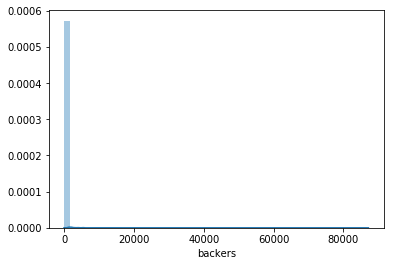

In [9]:
print("Backers distribution")
sns.distplot(data.backers);

Campaigns with >= 100 backers distribution


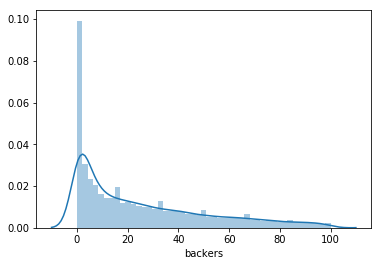

In [10]:
print("Campaigns with >= 100 backers distribution")
sns.distplot(data[data.backers <= 100].backers);

Duration distribution


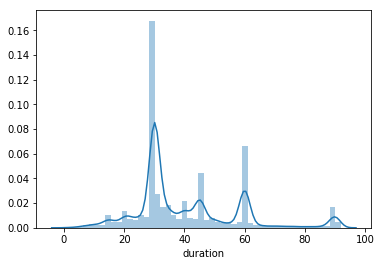

In [11]:
print("Duration distribution")
sns.distplot(data.duration);

Goal distribution


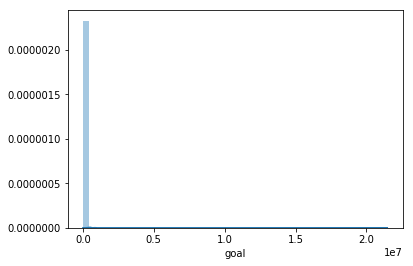

In [12]:
print("Goal distribution")
sns.distplot(data.goal);

Pledged distribution


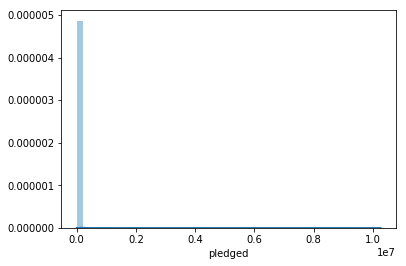

In [13]:
print("Pledged distribution")
sns.distplot(data[data.pledged>=0].pledged);

Funded percentage distribution


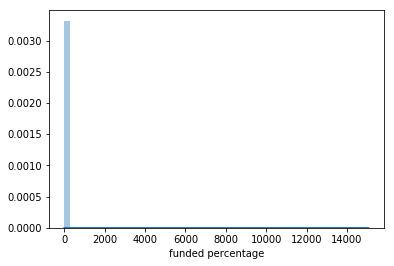

In [14]:
print("Funded percentage distribution")
sns.distplot(data["funded percentage"]);

Levels distribution


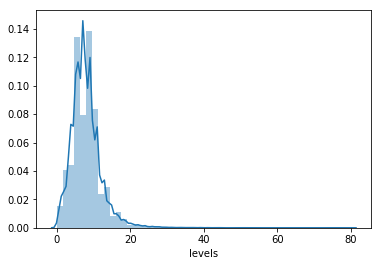

In [15]:
print("Levels distribution")
sns.distplot(data["levels"]);

Campaigns by status
successful    0.499793
failed        0.413343
live          0.085493
canceled      0.001284
suspended     0.000087
Name: status, dtype: float64


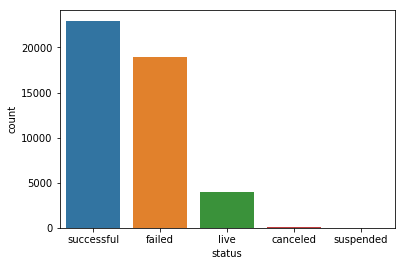

In [16]:
print("Campaigns by status")
print(data["status"].value_counts()/data["status"].count())
sns.countplot(data["status"]);

In [17]:
print("Examine funded percentage ranges")
data["funded_percent_int"] = data["funded percentage"].map(lambda d: int(d))

funded_bins = [0, 5, 10, 15, 20, 25, 50, 100, 1000]
funded_groups = ['0-5', '5-10', '10-15', '15-20','20-25','25-50','50-100','100-1000']
data['funded_percent_int_bins'] = pd.cut(data['funded_percent_int'], funded_bins, right=False, labels=funded_groups)
print(data['funded_percent_int_bins'].value_counts().sort_values(ascending=False)/data["funded_percent_int_bins"].count())

Examine funded percentage ranges
0-5         0.991011
5-10        0.005594
10-15       0.001197
15-20       0.000544
100-1000    0.000544
25-50       0.000479
20-25       0.000370
50-100      0.000261
Name: funded_percent_int_bins, dtype: float64


Examine duration vs campaign status
Best length of time to run a campaign: 30-60days


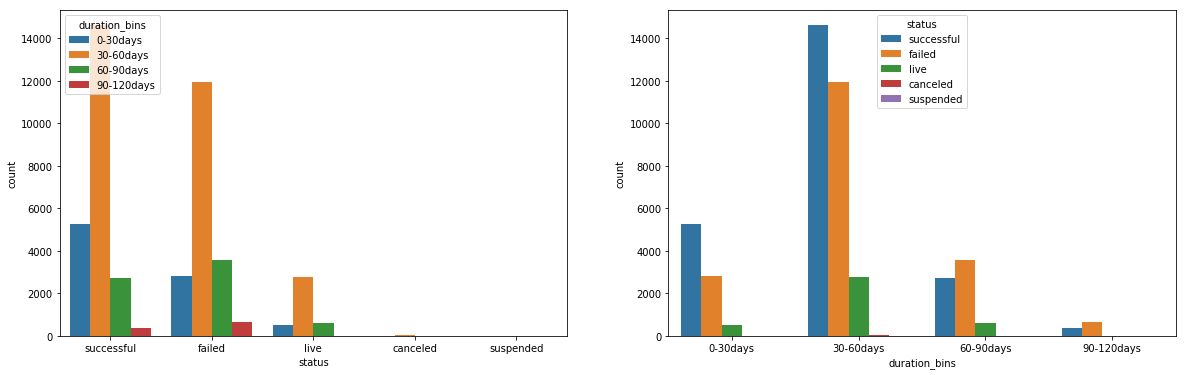

In [18]:
print("Examine duration vs campaign status")
data["duration_int"] = data.duration.map(lambda d: int(d))
# print(data["duration_int"].value_counts().sort_values(ascending=False).head())

# Define bins as 0 to 30, 30 to 60, 60 to 90, 90 to 120
days_bins = [0, 30, 60, 90, 120]
days_groups = ['0-30days', '30-60days', '60-90days', '90-120days']
data['duration_bins'] = pd.cut(data['duration_int'], days_bins, right=False, labels=days_groups)
# print(data['duration_bins'].value_counts().sort_values(ascending=False))

f, (ax1, ax2) = sns.mpl.pyplot.subplots(1, 2, figsize=(20,6))
sns.countplot(data=data, x='status',hue='duration_bins', ax=ax1)
sns.countplot(data=data, x='duration_bins',hue='status', ax=ax2);

print("Best length of time to run a campaign: 30-60days")

Examine goal vs campaign status
Ideal pledge goal: <= 5k


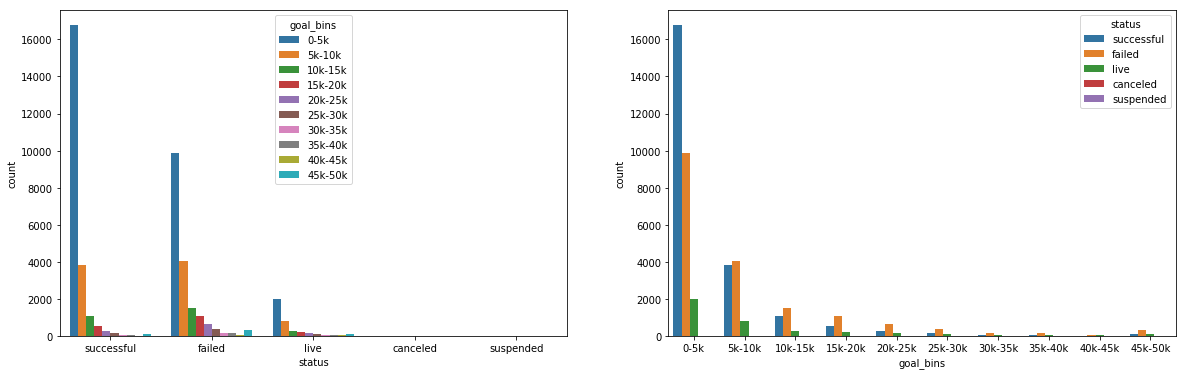

In [19]:
print("Examine goal vs campaign status")
goal_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
goal_groups = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-35k', '35k-40k', '40k-45k', '45k-50k']
data['goal_bins'] = pd.cut(data['goal'], goal_bins, right=True, labels=goal_groups)
# print(data['goal_bins'].value_counts().sort_values(ascending=False))

f, (ax1, ax2) = sns.mpl.pyplot.subplots(1, 2, figsize=(20,6))
sns.countplot(data=data, x='status',hue='goal_bins', ax=ax1)
sns.countplot(data=data, x='goal_bins',hue='status', ax=ax2);

print("Ideal pledge goal: <= 5k")

Examine levels vs campaign status


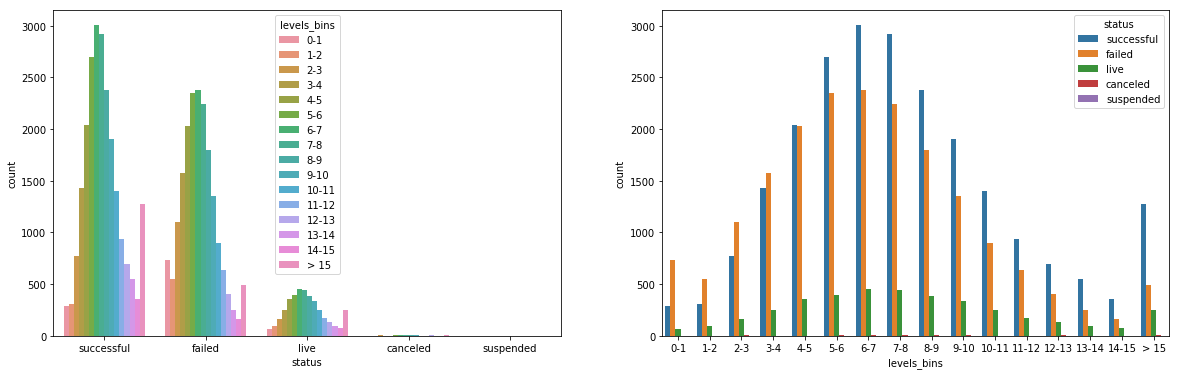

In [20]:
print("Examine levels vs campaign status")
levels_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1000]
levels_groups = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '> 15']
data['levels_bins'] = pd.cut(data['levels'], levels_bins, right=True, labels=levels_groups)
# print(data['levels_bins'].value_counts().sort_values(ascending=False))

f, (ax1, ax2) = sns.mpl.pyplot.subplots(1, 2, figsize=(20,6))
sns.countplot(data=data, x='status',hue='levels_bins', ax=ax1)
sns.countplot(data=data, x='levels_bins',hue='status', ax=ax2);

In [21]:
successful_campaigns = pd.DataFrame(data[data.status == "successful"])
print("Total successful campaigns: ", successful_campaigns.shape)

funded_campaigns = pd.DataFrame(successful_campaigns[successful_campaigns["funded percentage"] >= 100])
print("Total successful campaigns with >= 100% fund percentage: ", funded_campaigns.shape)

Total successful campaigns:  (22969, 23)
Total successful campaigns with >= 100% fund percentage:  (35, 23)


In [22]:
print("Examine funded percentage ranges for successful campaigns")
print(successful_campaigns['funded_percent_int_bins'].value_counts().sort_values(ascending=False)/successful_campaigns["funded_percent_int_bins"].count())

Examine funded percentage ranges for successful campaigns
0-5         0.983230
5-10        0.010454
10-15       0.002222
100-1000    0.001002
25-50       0.000958
15-20       0.000915
20-25       0.000697
50-100      0.000523
Name: funded_percent_int_bins, dtype: float64


Successful campaigns by category


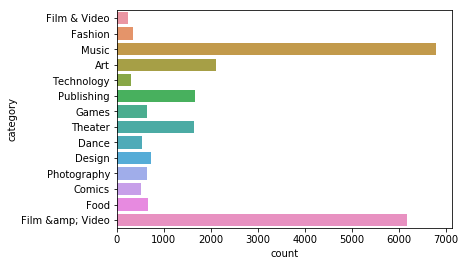

In [23]:
print("Successful campaigns by category")
sns.countplot(y=successful_campaigns["category"]);

Successful funded campaigns by category


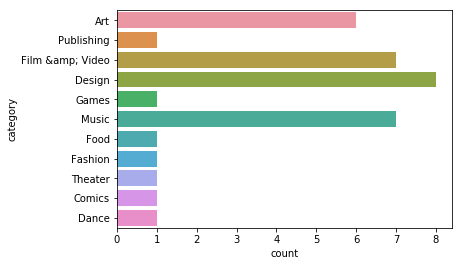

In [24]:
print("Successful funded campaigns by category")
sns.countplot(y=funded_campaigns["category"]);

Successful campaigns by location


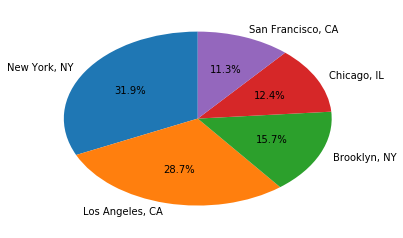

In [25]:
print("Successful campaigns by location")

top_locations = pd.DataFrame(successful_campaigns["location"].value_counts().sort_values(ascending=False).head().reset_index())
top_locations.columns = ["location","count"]

plt.pie(
    top_locations['count'],
    labels=top_locations['location'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by location


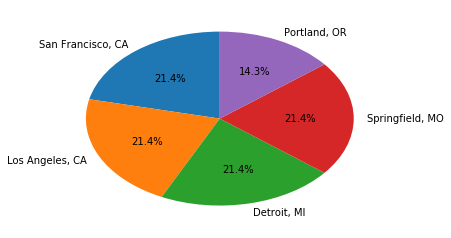

In [26]:
print("Successful funded campaigns by location")

top_locations = pd.DataFrame(funded_campaigns["location"].value_counts().sort_values(ascending=False).head().reset_index())
top_locations.columns = ["location","count"]

plt.pie(
    top_locations['count'],
    labels=top_locations['location'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

In [27]:
print("Successful campaigns by category and sub category")
successful_campaigns.groupby(['category', 'subcategory']).size()

Successful campaigns by category and sub category


category          subcategory           
Art               Art                        610
                  Conceptual Art              97
                  Digital Art                 65
                  Illustration               111
                  Mixed Media                198
                  Painting                   242
                  Performance Art            270
                  Public Art                 335
                  Sculpture                  178
Comics            Comics                     520
Dance             Dance                      527
Design            Crafts                     105
                  Design                     133
                  Graphic Design              97
                  Product Design             394
Fashion           Fashion                    335
Film & Video      Animation                    4
                  Documentary                 63
                  Film &amp; Video            33
                  Narrative 

In [28]:
print("Successful funded campaigns by category and sub category")
funded_campaigns.groupby(['category', 'subcategory']).size()

Successful funded campaigns by category and sub category


category          subcategory           
Art               Art                       2
                  Conceptual Art            2
                  Sculpture                 2
Comics            Comics                    1
Dance             Dance                     1
Design            Crafts                    1
                  Graphic Design            4
                  Product Design            3
Fashion           Fashion                   1
Film &amp; Video  Documentary               1
                  Film &amp; Video          1
                  Narrative Film            4
                  Short Film                1
Food              Food                      1
Games             Board &amp; Card Games    1
Music             Classical Music           2
                  Country &amp; Folk        2
                  Indie Rock                2
                  Music                     1
Publishing        Publishing                1
Theater           Theater              

Successful campaigns by business day or weekend


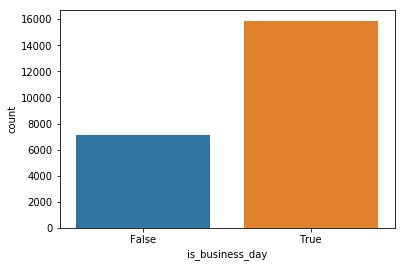

In [29]:
print("Successful campaigns by business day or weekend")
successful_campaigns["funded_dt"] = pd.to_datetime(successful_campaigns["funded date"])
successful_campaigns["is_business_day"] = np.is_busday(successful_campaigns.funded_dt.values.astype('datetime64[D]'))
sns.countplot(successful_campaigns["is_business_day"]);

Successful funded campaigns by business day or weekend


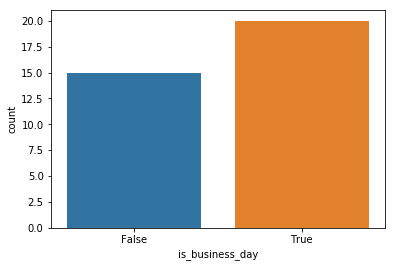

In [30]:
print("Successful funded campaigns by business day or weekend")
funded_campaigns["funded_dt"] = pd.to_datetime(funded_campaigns["funded date"])
funded_campaigns["is_business_day"] = np.is_busday(funded_campaigns.funded_dt.values.astype('datetime64[D]'))
sns.countplot(funded_campaigns["is_business_day"]);

Successful campaigns by day of the week


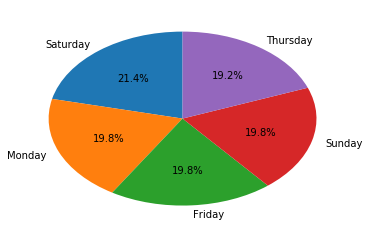

In [31]:
print("Successful campaigns by day of the week")

df = pd.DataFrame(successful_campaigns["funded_dt"].dt.strftime("%A").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["day","count"]

plt.pie(
    df['count'],
    labels=df['day'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by day of the week


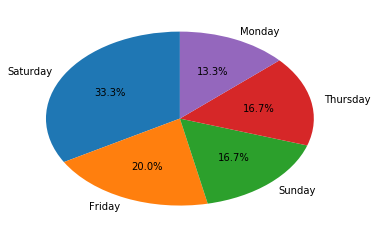

In [32]:
print("Successful funded campaigns by day of the week")

df = pd.DataFrame(funded_campaigns["funded_dt"].dt.strftime("%A").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["day","count"]

plt.pie(
    df['count'],
    labels=df['day'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful campaigns by month


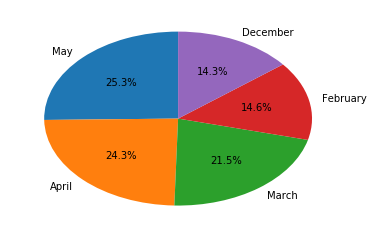

In [33]:
print("Successful campaigns by month")

df = pd.DataFrame(successful_campaigns["funded_dt"].dt.strftime("%B").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["month","count"]

plt.pie(
    df['count'],
    labels=df['month'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by month


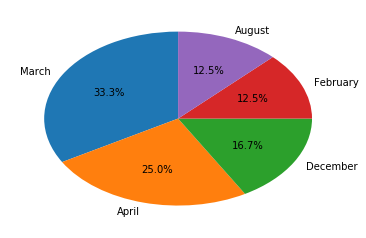

In [34]:
print("Successful funded campaigns by month")

df = pd.DataFrame(funded_campaigns["funded_dt"].dt.strftime("%B").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["month","count"]

plt.pie(
    df['count'],
    labels=df['month'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful campaigns by hour


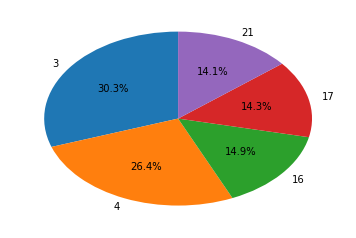

In [35]:
print("Successful campaigns by hour")

df = pd.DataFrame(successful_campaigns["funded_dt"].dt.hour.value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["hour","count"]

plt.pie(
    df['count'],
    labels=df['hour'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by hour


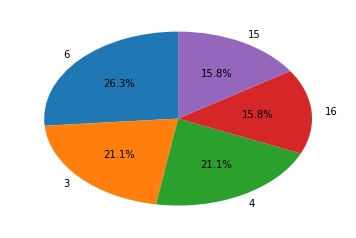

In [36]:
print("Successful funded campaigns by hour")

df = pd.DataFrame(funded_campaigns["funded_dt"].dt.hour.value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["hour","count"]

plt.pie(
    df['count'],
    labels=df['hour'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

### For modeling, visit:

https://github.com/iamontheinet/datascience/blob/master/kickstarter_campaigns/notebooks/Kickstarter%20Campaigns%20Modeling.ipynb